<a href="https://colab.research.google.com/github/matanlakker/BINA/blob/main/eda_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

#import sweetviz as sv

import os

import math

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from sklearn.impute import KNNImputer, SimpleImputer

from scipy import stats
from scipy.stats import norm, ttest_ind, f_oneway, kruskal, spearmanr, pearsonr, skew, kurtosis, chi2_contingency, mannwhitneyu, ks_2samp

import warnings

import itertools

warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from Google Drive
file_path = '/content/drive/MyDrive/BINA PROJECT/Cleaned-Data-TABLE.csv'
data = pd.read_csv(file_path)

# Map severity columns into a single column
severity_mapping = {
    'Severity_None': 0,
    'Severity_Mild': 1,
    'Severity_Moderate': 2,
    'Severity_Severe': 3
}

# Create the new "Severity" column and drop the old columns
data['Severity'] = (
    data[['Severity_None', 'Severity_Mild', 'Severity_Moderate', 'Severity_Severe']]
    .idxmax(axis=1)
    .map(severity_mapping)
)
data = data.drop(columns=['Severity_None', 'Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Country'])

# Split features and labels
X = data.drop(columns=['Severity']).values  # Features
y = data['Severity'].values  # Labels

# Convert labels to categorical (one-hot encoding for multi-class classification)
y_categorical = to_categorical(y, num_classes=4)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Data Overview:")
print(data.info())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Fever                    316800 non-null  int64
 1   Tiredness                316800 non-null  int64
 2   Dry-Cough                316800 non-null  int64
 3   Difficulty-in-Breathing  316800 non-null  int64
 4   Sore-Throat              316800 non-null  int64
 5   None_Sympton             316800 non-null  int64
 6   Pains                    316800 non-null  int64
 7   Nasal-Congestion         316800 non-null  int64
 8   Runny-Nose               316800 non-null  int64
 9   Diarrhea                 316800 non-null  int64
 10  None_Experiencing        316800 non-null  int64
 11  Age_0-9                  316800 non-null  int64
 12  Age_10-19                316800 non-null  int64
 13  Age_20-24                316800 non-null  int64
 14  Age_25-59            

In [ ]:
# prompt: make all columns categorial and make the severity column with order

# Assuming 'data' DataFrame is already loaded as in the provided code.

# Convert all columns to categorical
for col in data.columns:
    data[col] = pd.Categorical(data[col])

# Define the order for the 'Severity' column
severity_order = [0, 1, 2, 3]  # Assuming 0: None, 1: Mild, 2: Moderate, 3:Severe

# Convert 'Severity' to an ordered categorical type
data['Severity'] = pd.Categorical(data['Severity'], categories=severity_order, ordered=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Fever                    316800 non-null  category
 1   Tiredness                316800 non-null  category
 2   Dry-Cough                316800 non-null  category
 3   Difficulty-in-Breathing  316800 non-null  category
 4   Sore-Throat              316800 non-null  category
 5   None_Sympton             316800 non-null  category
 6   Pains                    316800 non-null  category
 7   Nasal-Congestion         316800 non-null  category
 8   Runny-Nose               316800 non-null  category
 9   Diarrhea                 316800 non-null  category
 10  None_Experiencing        316800 non-null  category
 11  Age_0-9                  316800 non-null  category
 12  Age_10-19                316800 non-null  category
 13  Age_20-24                316800 non-null  ca

Number of significant pairs: 40


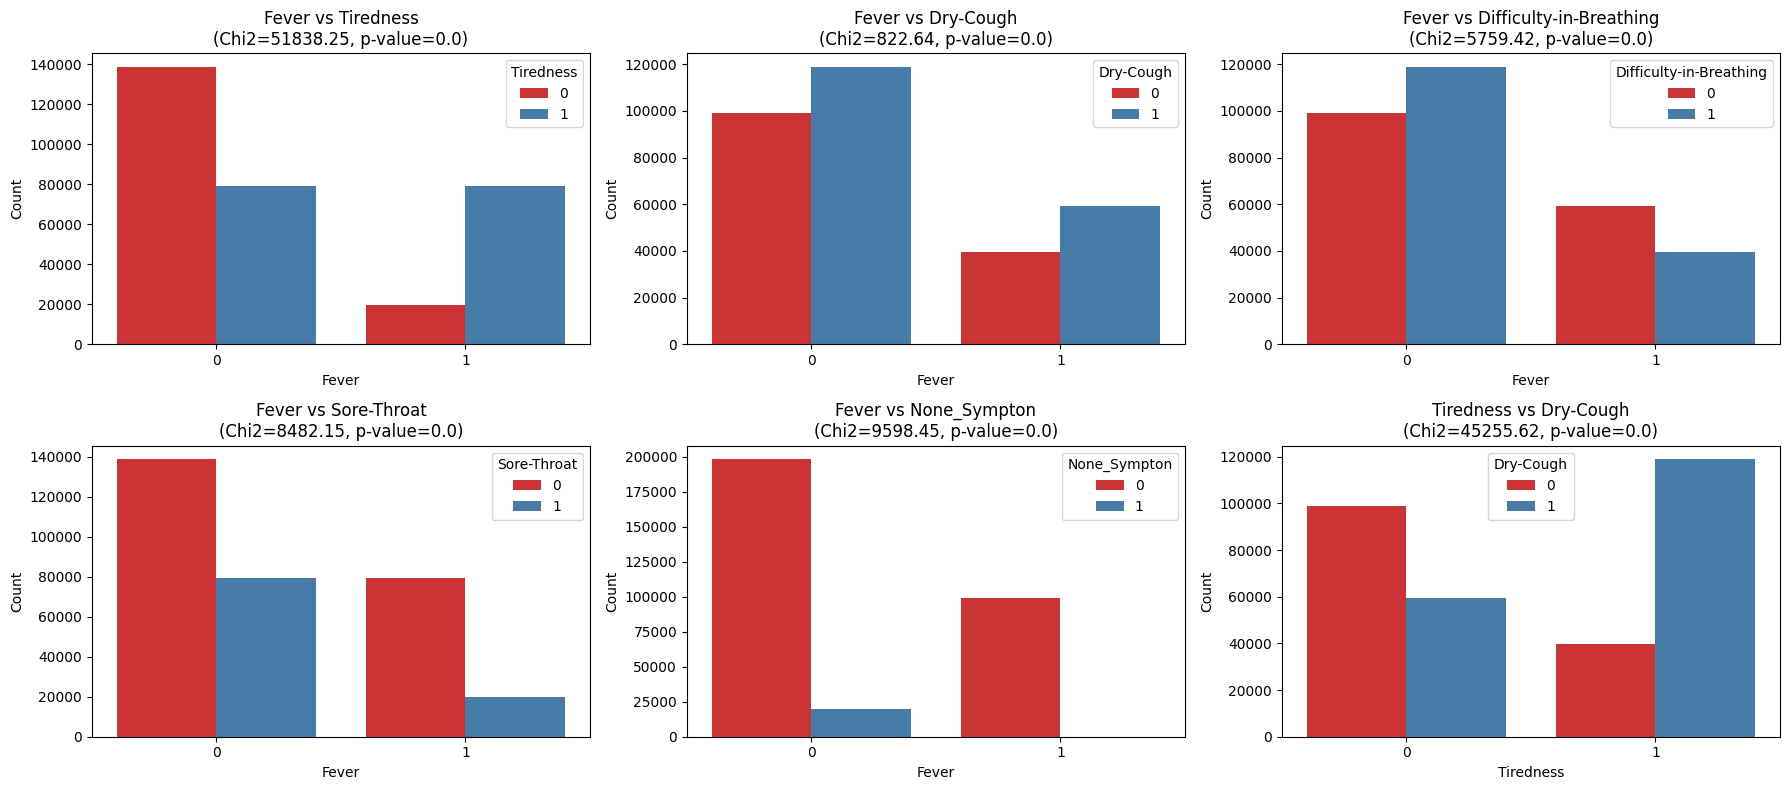

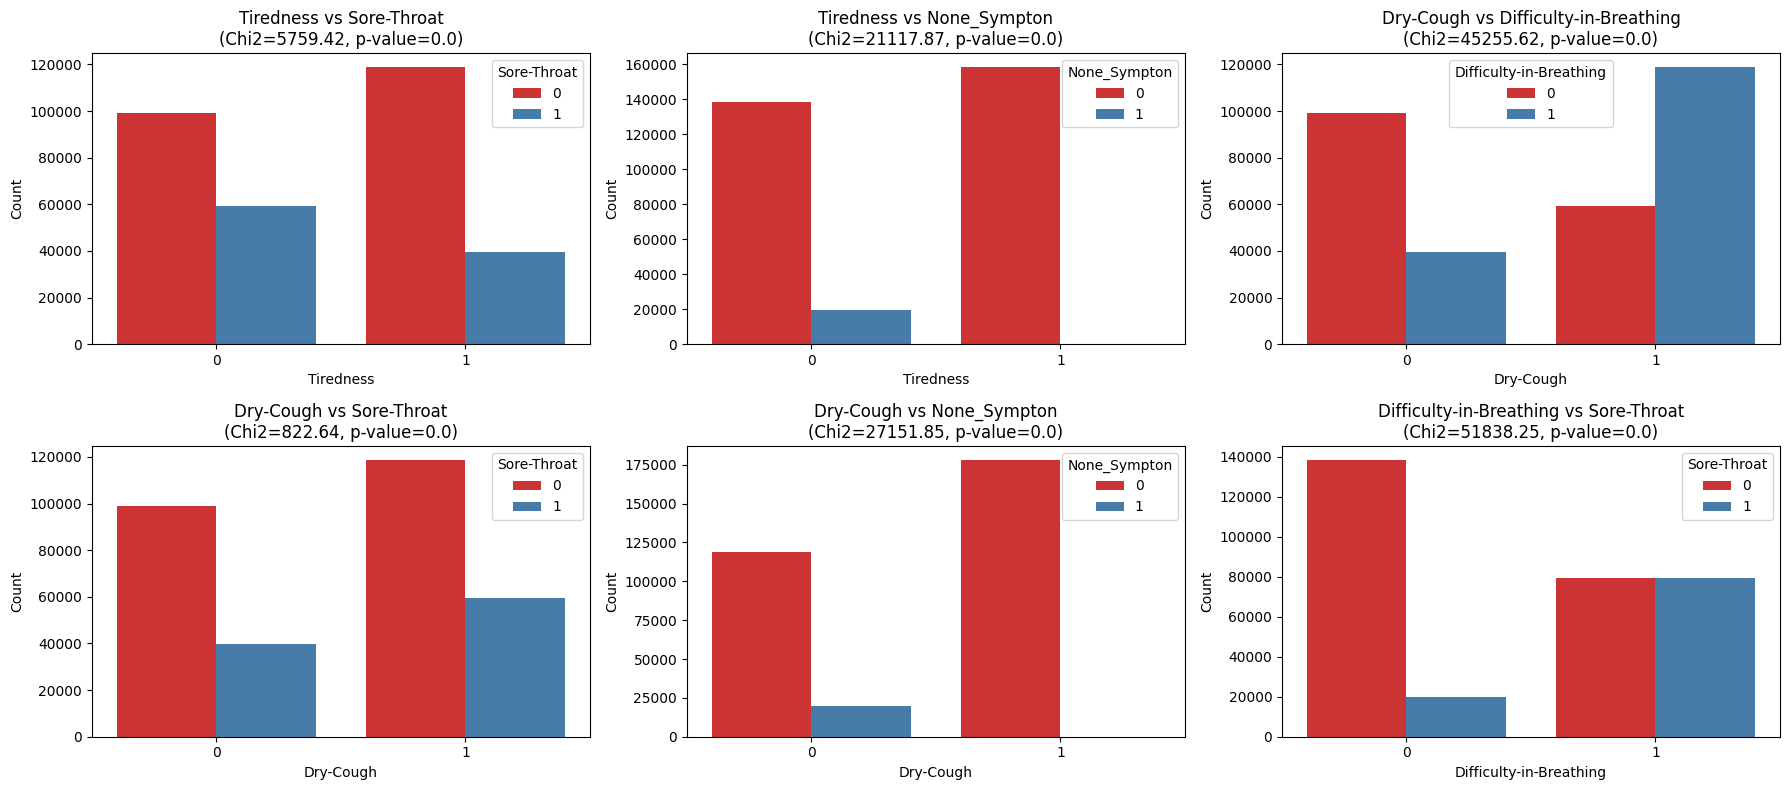

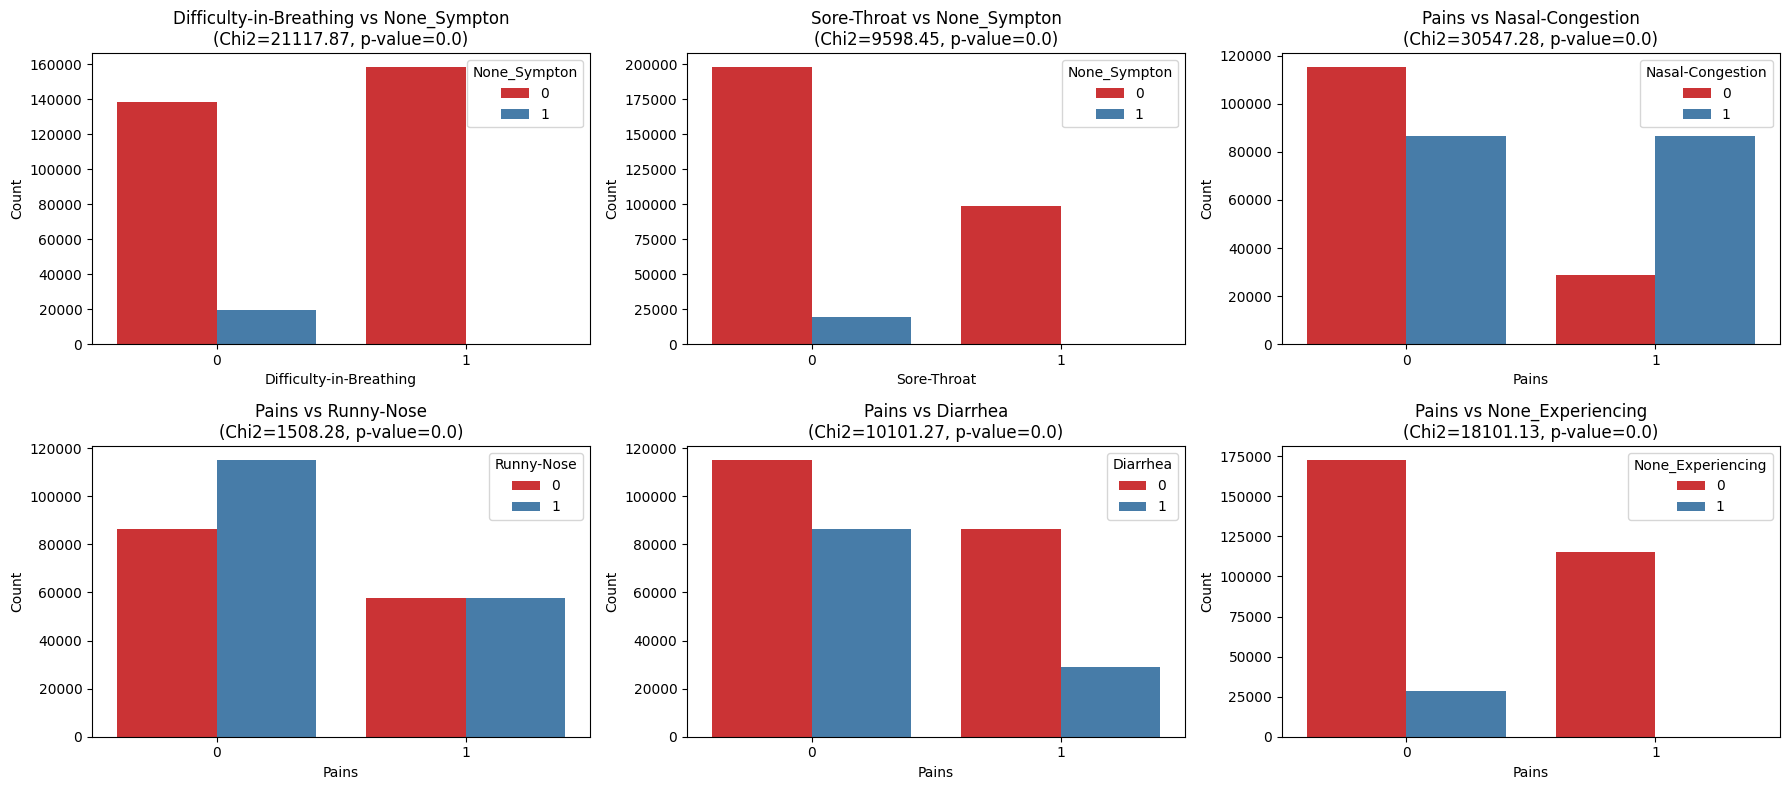

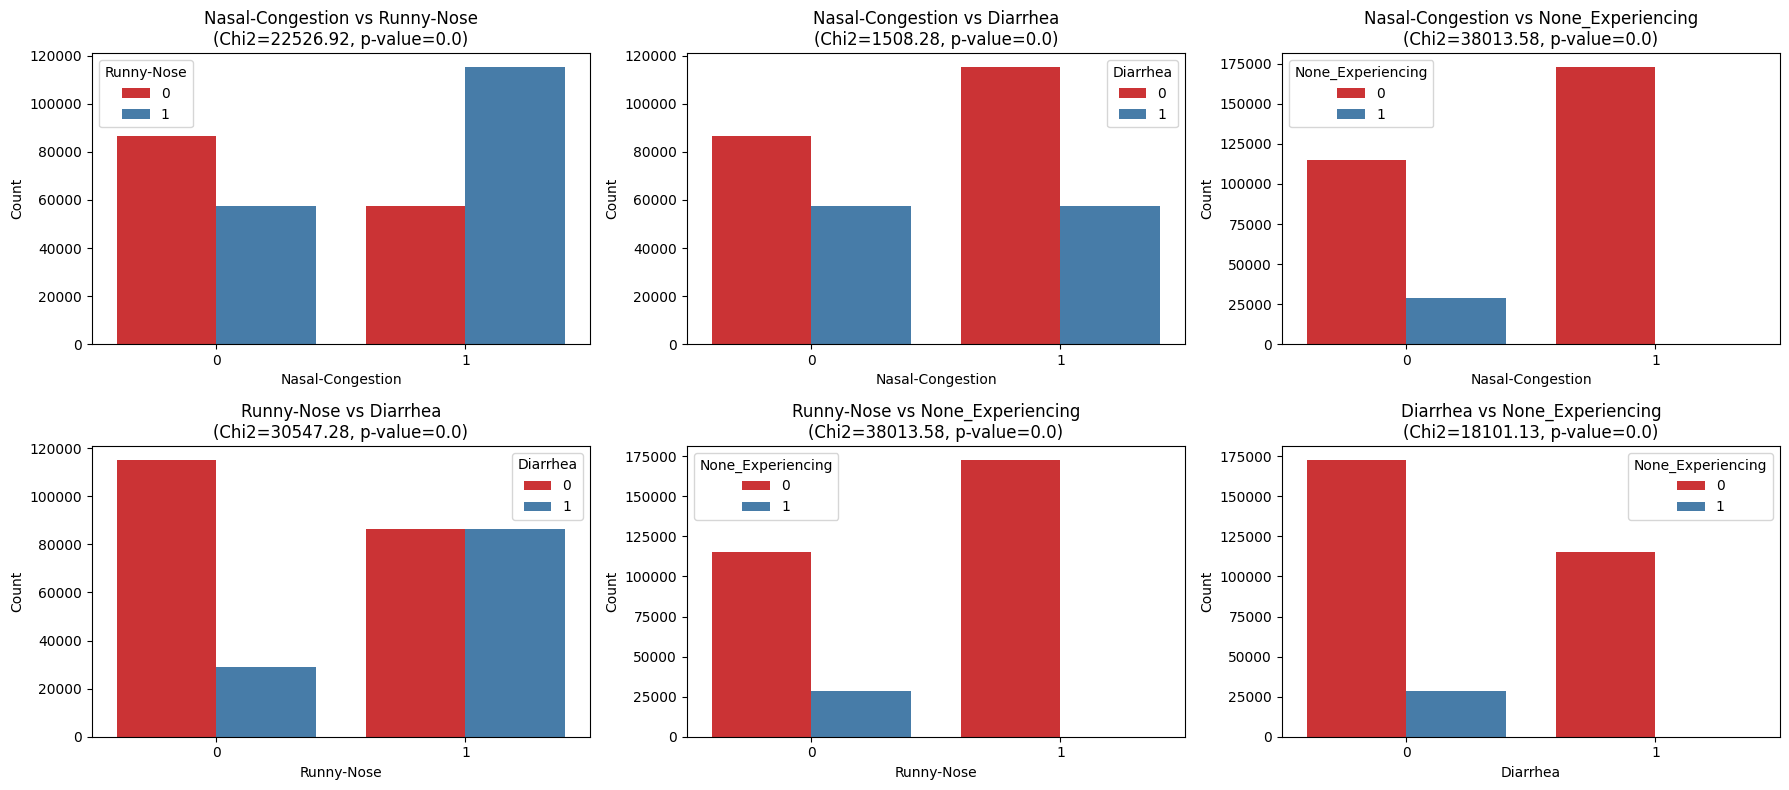

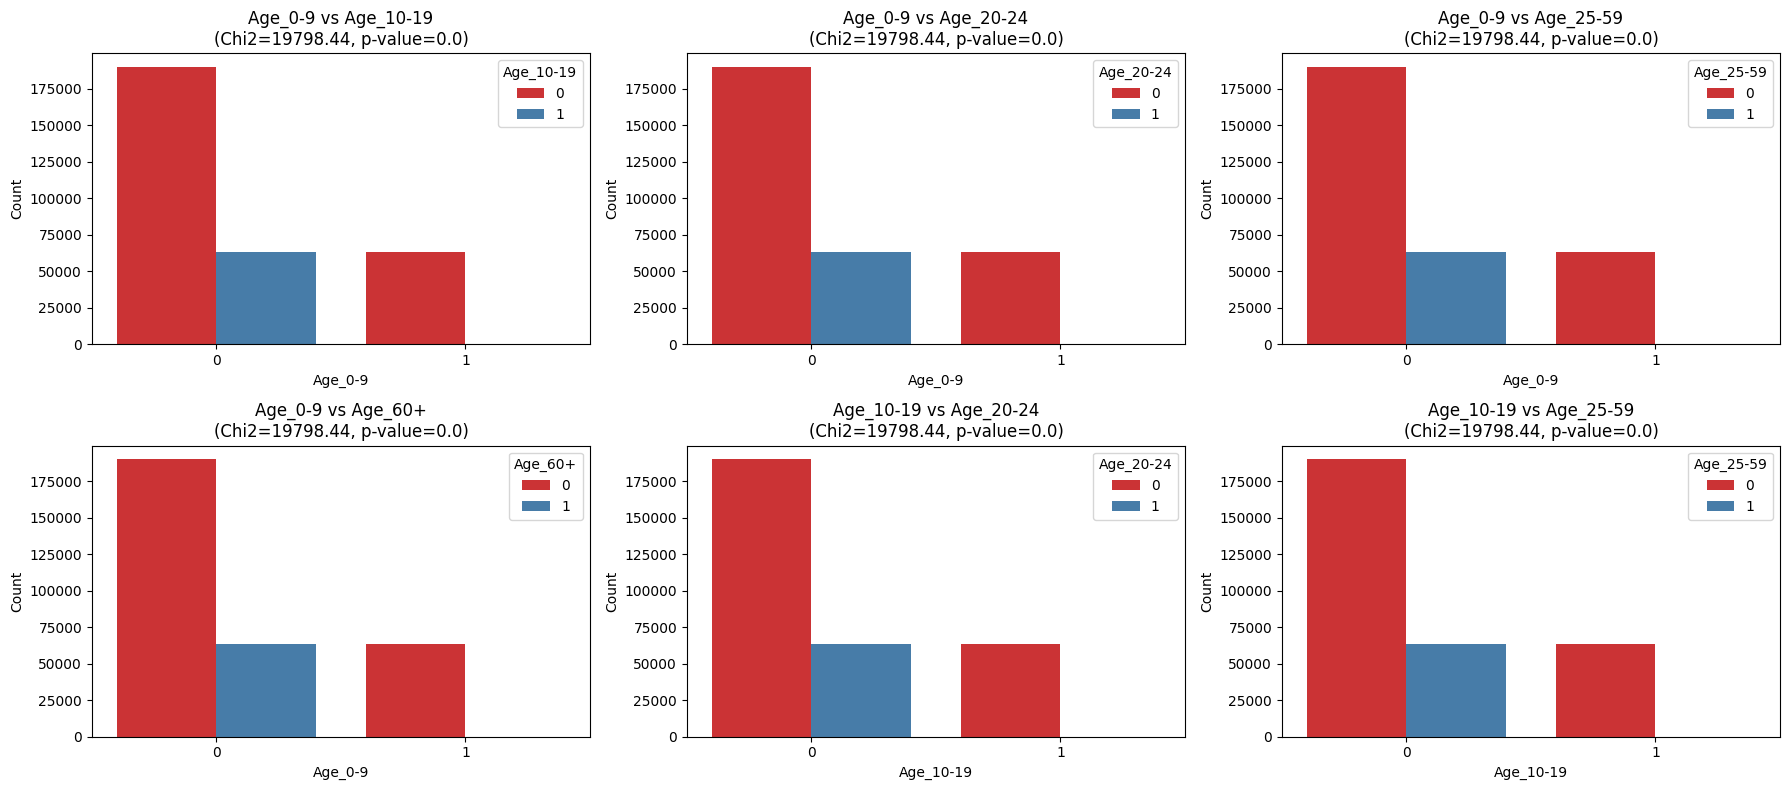

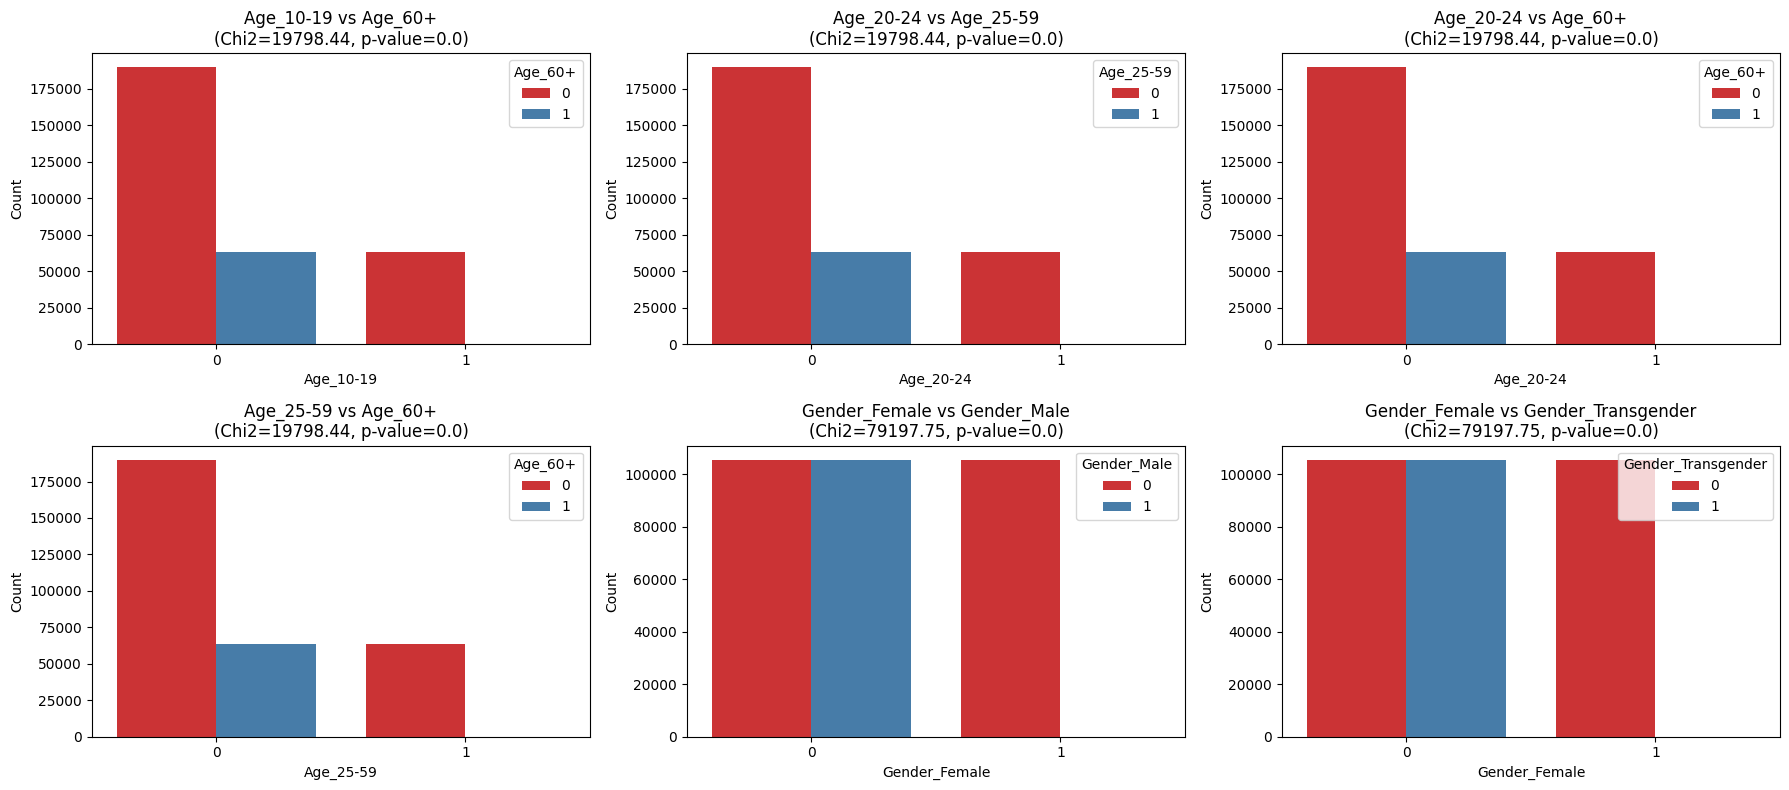

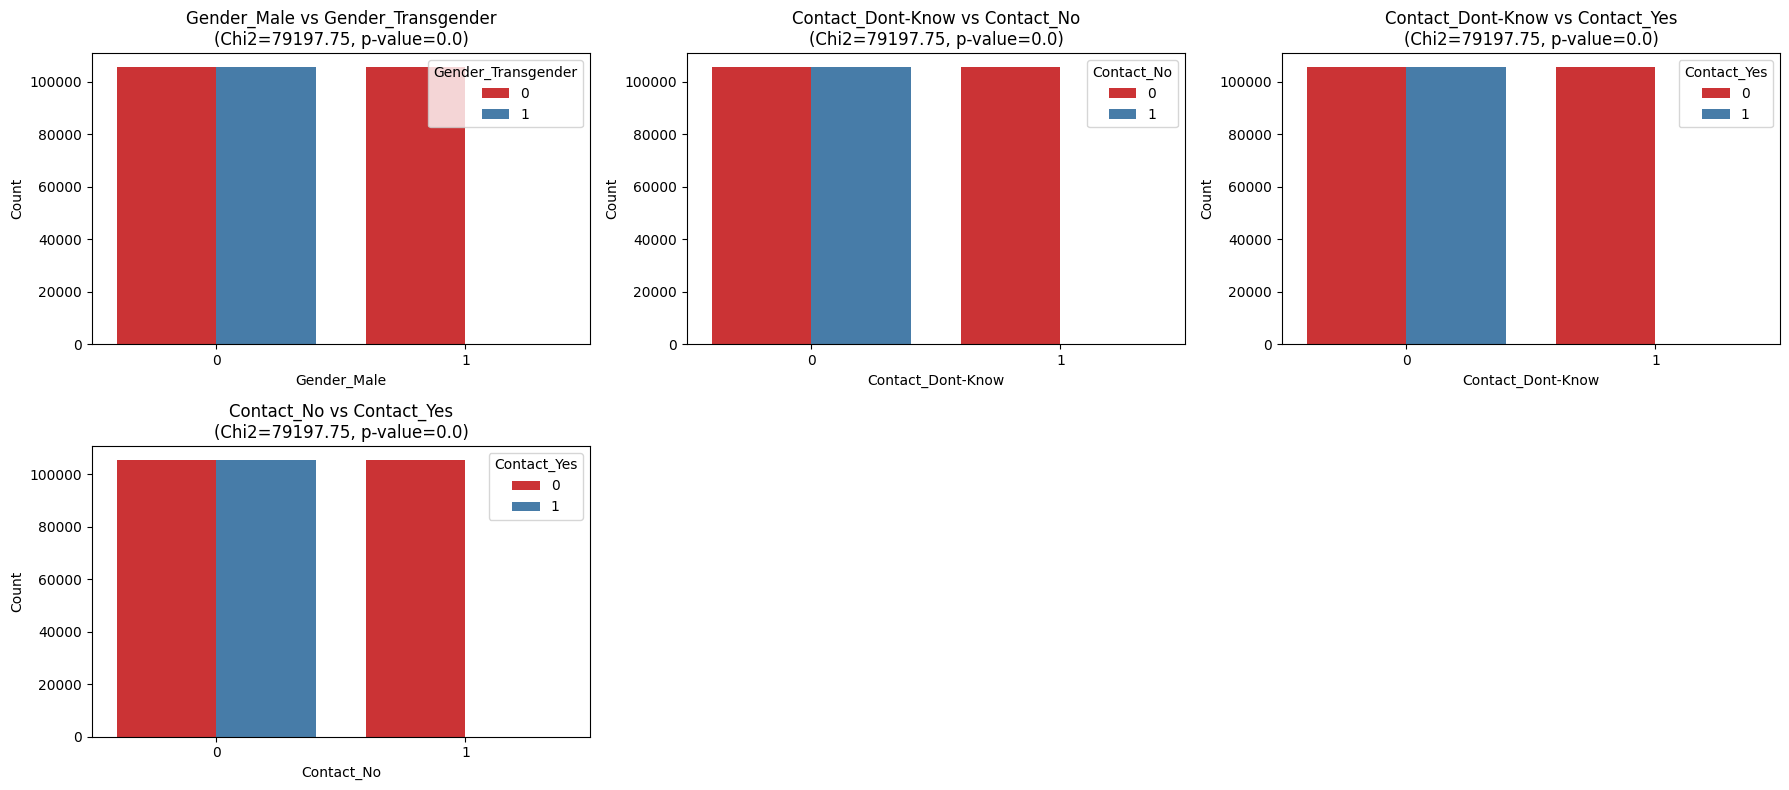

Total number of graphs created: 40


In [ ]:
# Select categorical variables
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Create unique pairs of categorical variables
cat_pairs = [(var1, var2) for i, var1 in enumerate(categorical_cols) for var2 in categorical_cols[i + 1:]]

significant_pairs = []

# Perform Chi-Square Test
for var1, var2 in cat_pairs:
    # Create contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])

    # Perform Chi-Square Test
    try:
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # Save pairs with p-value < 0.05
        if p_value < 0.05:
            significant_pairs.append((var1, var2, chi2, p_value))
    except Exception as e:
        print(f"Skipping {var1} vs {var2} due to error: {e}")
        continue

# Print number of significant pairs
print(f"Number of significant pairs: {len(significant_pairs)}")

# Parameters for plot layout
graphs_per_row = 3  # Number of graphs per row
graphs_per_page = graphs_per_row * 2  # Total graphs per page (2 rows)

# Split graphs into pages
for start in range(0, len(significant_pairs), graphs_per_page):
    current_pairs = significant_pairs[start:start + graphs_per_page]
    rows = (len(current_pairs) + graphs_per_row - 1) // graphs_per_row  # Dynamic number of rows

    # Create subplots
    fig, axes = plt.subplots(rows, graphs_per_row, figsize=(graphs_per_row * 6, rows * 4))

    # Ensure axes is an array even if there's only one row
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Generate graphs
    for idx, (var1, var2, chi2, p_value) in enumerate(current_pairs):
        sns.countplot(x=data[var1], hue=data[var2], palette="Set1", ax=axes[idx])
        axes[idx].set_title(f"{var1} vs {var2}\n(Chi2={round(chi2, 2)}, p-value={round(p_value, 3)})")
        axes[idx].set_xlabel(var1)
        axes[idx].set_ylabel("Count")

    # Hide unused axes if fewer graphs than total slots
    for ax in axes[len(current_pairs):]:
        ax.axis("off")

    # Display the graphs
    plt.tight_layout()
    plt.show()

# Create a DataFrame for significant pairs
significant_pairs_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Chi-Square', 'p-value'])

# Print total number of graphs created
print(f"Total number of graphs created: {len(significant_pairs)}")

# Save DataFrame to CSV
significant_pairs_df.to_csv('chi_square_results.csv', index=False)

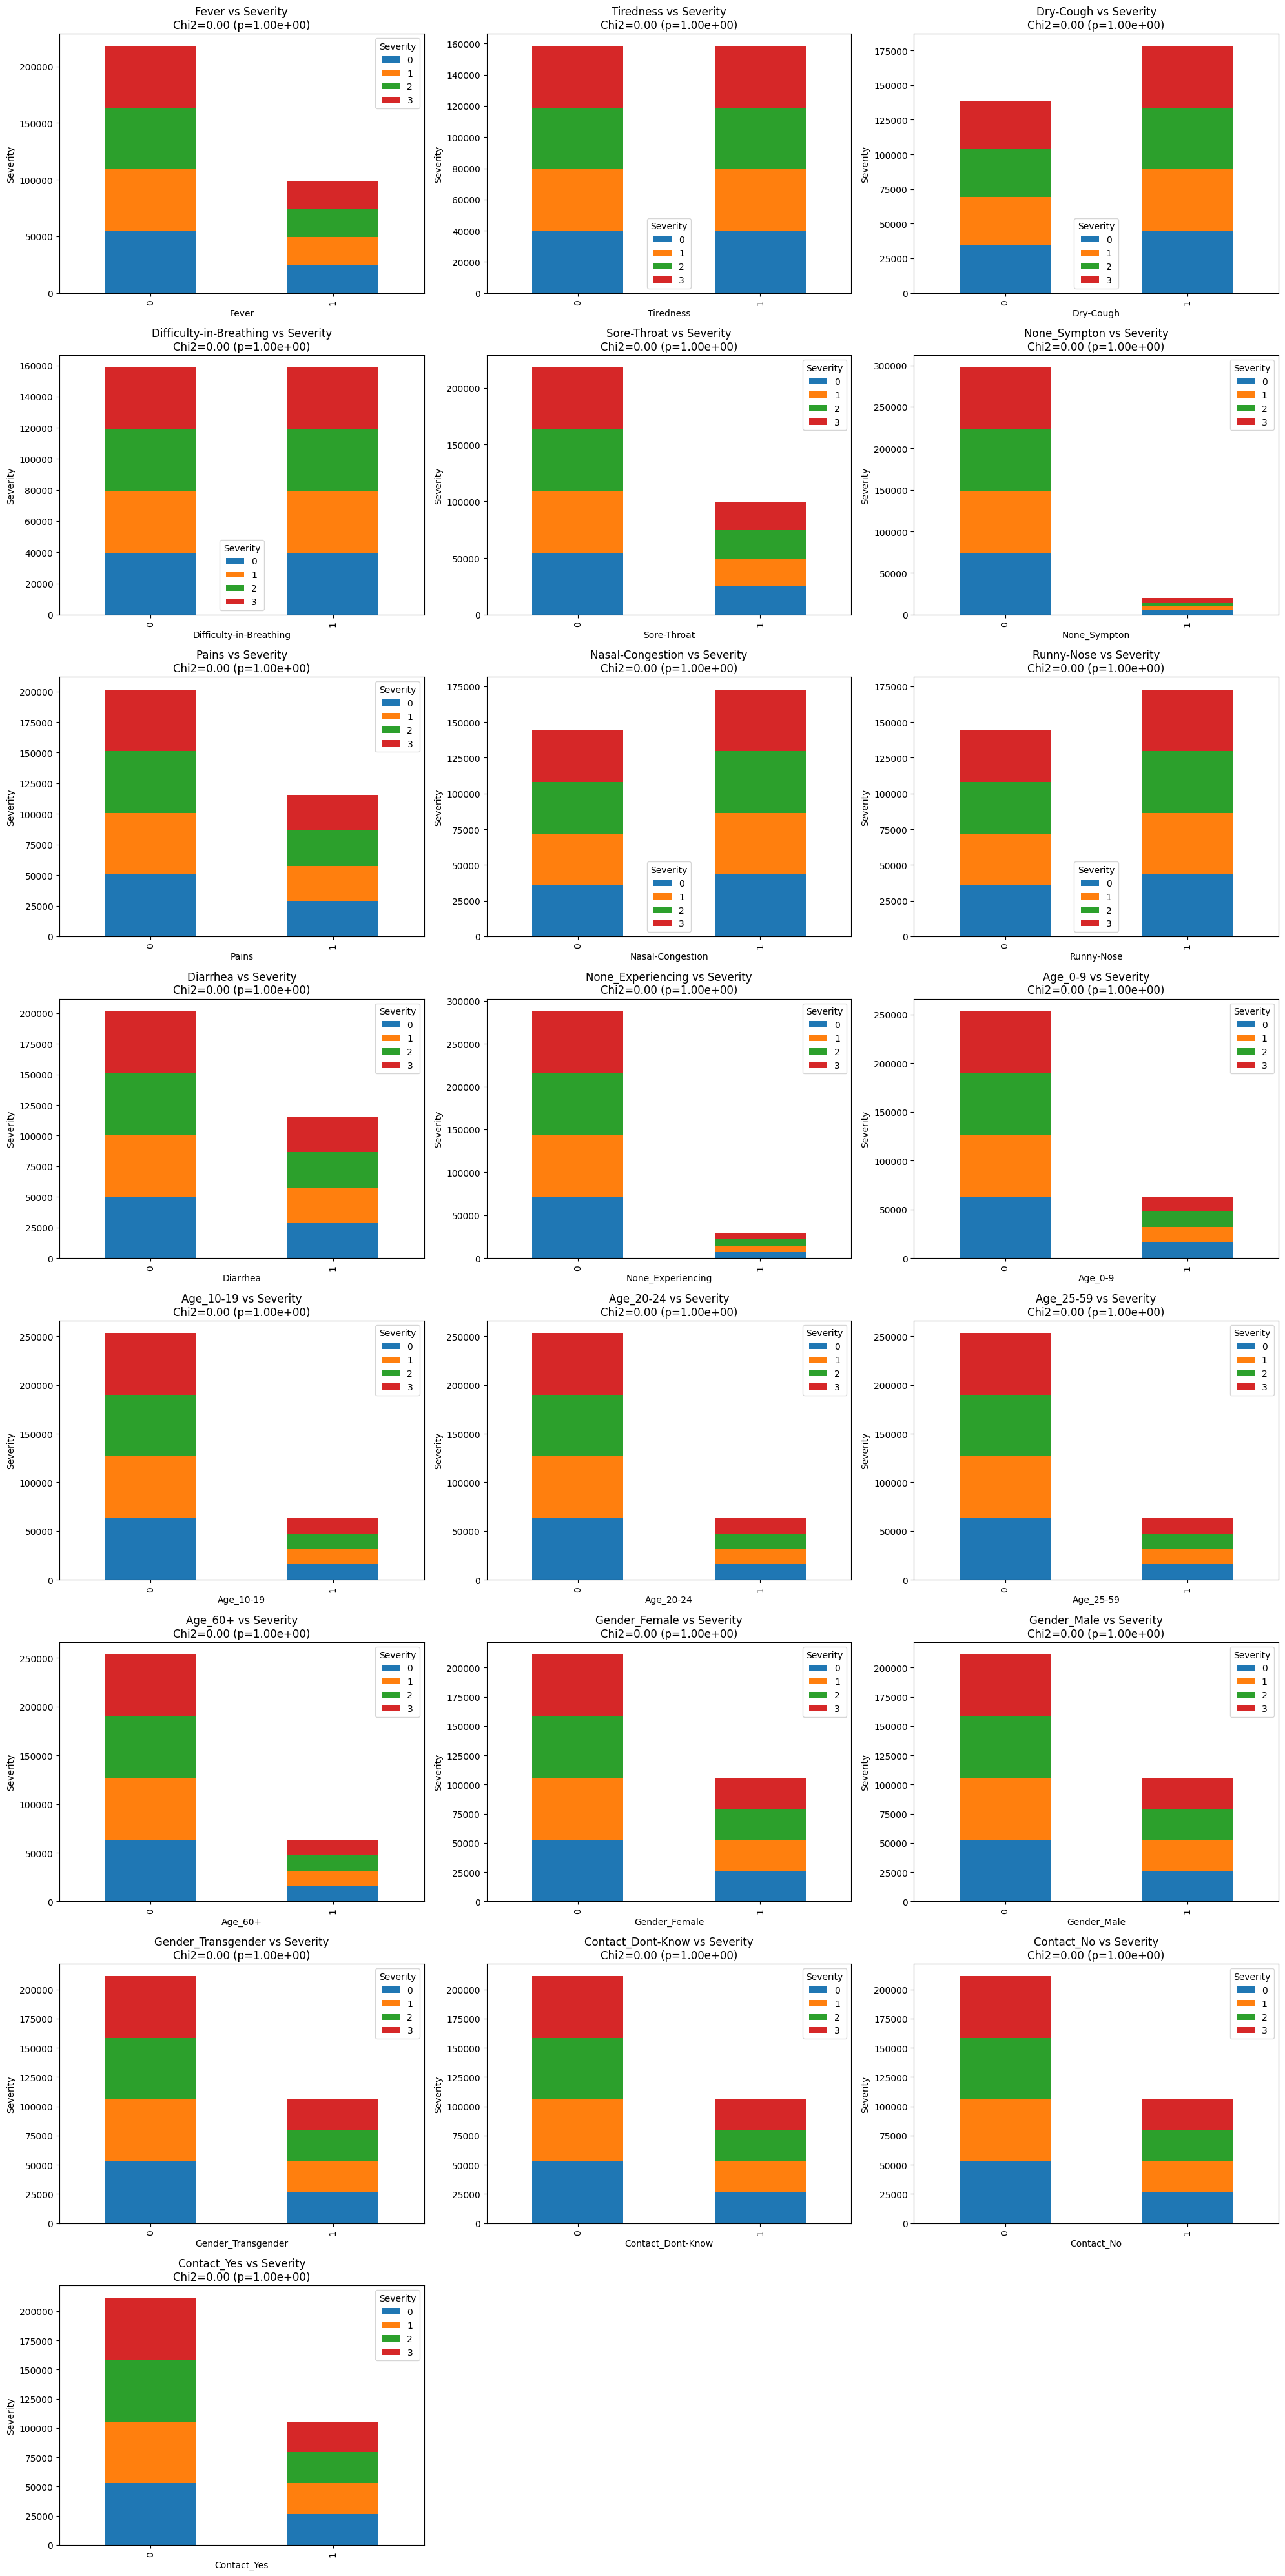

Analysis Summary:
                  Variable              Test  Value  P-Value
0                    Fever  Chi-squared Test    0.0      1.0
1                Tiredness  Chi-squared Test    0.0      1.0
2                Dry-Cough  Chi-squared Test    0.0      1.0
3  Difficulty-in-Breathing  Chi-squared Test    0.0      1.0
4              Sore-Throat  Chi-squared Test    0.0      1.0
The analysis summary has been saved to 'analysis_summary.csv'.


In [ ]:
# Create a DataFrame to store test results
results = []

# Calculate the number of columns for visualization
num_plots_per_row = 3

# Loop through all columns and compare them to 'Severity'
columns_to_analyze = [col for col in data.columns if col != 'Severity']
num_columns = len(columns_to_analyze)

fig, axes = plt.subplots(
    nrows=math.ceil(num_columns / num_plots_per_row),
    ncols=num_plots_per_row,
    figsize=(20, math.ceil(num_columns / num_plots_per_row) * 5),
)
axes = axes.flatten()

for i, col in enumerate(columns_to_analyze):
    ax = axes[i]

    if pd.api.types.is_numeric_dtype(data[col]) and pd.api.types.is_numeric_dtype(data['Severity']):
        # Numeric vs Numeric
        correlation, p_value = spearmanr(data[col], data['Severity'], nan_policy='omit')
        results.append({'Variable': col, 'Test': 'Spearman Correlation', 'Value': correlation, 'P-Value': p_value})

        sns.regplot(x=df[col], y=df['Severity'], scatter_kws={'alpha': 0.5}, ax=ax)
        ax.set_title(f"{col} vs dead_5y\nCorrelation: {correlation:.2f} (p={p_value:.2e})")

    elif pd.api.types.is_categorical_dtype(data[col]) or data[col].dtype == 'object':
        # Categorical vs Categorical
        contingency_table = pd.crosstab(data[col], data['Severity'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results.append({'Variable': col, 'Test': 'Chi-squared Test', 'Value': chi2, 'P-Value': p})

        contingency_table.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f"{col} vs Severity\nChi2={chi2:.2f} (p={p:.2e})")

    else:
        # Mixed types
        sns.boxplot(x=df['Severity'], y=df[col], ax=ax)
        ax.set_title(f"{col} vs Severity")

    ax.set_xlabel(col)
    ax.set_ylabel('Severity')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Save the summarized results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('analysis_summary.csv', index=False)

# Display the first few rows of the results summary in the console
print("Analysis Summary:")
print(results_df.head())

# Notify user where the CSV file is saved
print("The analysis summary has been saved to 'analysis_summary.csv'.")